In [1]:
# Standard Python modules
import os, sys
import yaml
import glob
import numpy as np
import pandas as pd
import xarray as xr
import xoak

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline

# import personal modules
# Path to modules
sys.path.append('../../modules')
from ar_funcs import AR_rank
from wrf_preprocess import preprocess_2Dvar
import nclcmaps as nclc
from plotter import draw_basemap

In [2]:
# Set up paths
server = 'skyriver'
if server == 'skyriver':
    path_to_data = '/home/dnash/comet_data/'
    path_to_wrf = path_to_data + 'downloads/wrf-AK/'
elif server == 'comet':
    path_to_data = '/cw3e/mead/projects/cwp140/scratch/dnash/data/'      # project data -- read only
    path_to_work = '/cw3e/mead/projects/cwp140/scratch/dnash/data/preprocessed/SEAK-WRF-precip/'
    path_to_wrf = path_to_data + 'downloads/SEAK-WRF/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
### TODO: make a yaml dict
ext1 = [-141., -130., 54., 61.] # extent of SEAK 
ext2 = [-150., -129., 53, 62]

## six communities
# -135.4519	58.1122, Hoonah (PAOH) 
# -135.3277	59.4538, Skagway (PAGY)
# -135.8894, 59.3988, Klukwan
# -139.671	59.5121, Yakutat (PAYA)
# -133.1358, 55.4769, Craig
# -132.4009, 55.5400, Kasaan

xs = [-135.4519, -135.3277, -135.8894, -139.671, -133.1358, -132.4009]
ys = [58.1122, 59.4538, 59.3988, 59.5121, 55.4769, 55.5400]
lbl1 = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']
lbl_align = ['center', 'left', 'right', 'center', 'right', 'center'] # where the labels go

## closest station
# -135.4519	58.1122, Hoonah (PAOH) 
# -135.3277	59.4538, Skagway (PAGY)
# -135.5117	59.2429, Haines (PAHN)
# -139.671	59.5121, Yakutat (PAYA)
# -133.076	55.5792, Klawock (PAKW)
# -131.7117	55.3567, Ketchikan (PAKT)
xs2 = [-135.4519, -135.3277, -135.5117, -139.671, -133.076, -131.7117]
ys2 = [58.1122, 59.4538, 59.2429, 59.5121, 55.5792, 55.3567]
lbl2 = ['PAOH', 'PAGY', 'PAHN', 'PAYA', 'PAKW', 'PAKT']

In [4]:
for i, (slon, slat) in enumerate(zip(xs, ys)):
    print(slon, slat)

-135.4519 58.1122
-135.3277 59.4538
-135.8894 59.3988
-139.671 59.5121
-133.1358 55.4769
-132.4009 55.54


### Import preprocessed WRF data

In [5]:
# %%time
# # get list of filenames that contain data from that year from current year folder
# year = '1992'
# varname = 'PCPT'
# filenames = []
# for name in glob.glob(path_to_data + 'preprocessed/SEAK-WRF-{0}/WRFDS_{0}_{1}.nc'.format(varname, year)):
#     filenames.append(name)
# # sort filenames so they are in chronological order
# filenames = sorted(filenames)
# print(filenames)
# wrf = xr.open_mfdataset(filenames, combine='by_coords')

# # wrf = preprocess_PCPT_test(filenames)
# # wrf = preprocess_2Dvar(filenames, output_varname)
# # wrf = preprocess_PCPT(filenames)
# # wrf = preprocess_2Dvar_new(filenames, output_varname)


# # wrf

In [6]:
year = '2010'
varname = 'PCPT'
fname = path_to_data + 'preprocessed/SEAK-WRF-{0}/WRFDS_{0}_{1}.nc'.format(varname, year)
print(fname)

/home/dnash/comet_data/preprocessed/SEAK-WRF-PCPT/WRFDS_PCPT_2010.nc


In [7]:
wrf = xr.open_dataset(fname)
# wrf = wrf.resample(time="1D").sum('time')
wrf

<xarray.Dataset>
Dimensions:  (time: 8760, y: 250, x: 320)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 ... 2010-12-31T23:00:00
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...
Dimensions without coordinates: y, x
Data variables:
    PCPT     (time, y, x) float32 ...
Attributes:
    contact:  rtladerjr@alaska.edu
    info:     Alaska CASC
    data:     Downscaled CFSR
    format:   version 1
    date:     Fri May  3 12:17:58 AKDT 2019

In [8]:
from scipy import spatial

## write a new method for selecting lat lons
slon = -135.8894
slat = 59.3988

lon2d = wrf.lon.values
lat2d = wrf.lat.values

# zip them together
model_grid = list( zip(np.ravel(lon2d), np.ravel(lat2d)) ) 

#target point location : 30.5N, 56.1E
target_pts = [slat, slon]   
distance, index = spatial.KDTree(model_grid).query(target_pts)
# the nearest model location (in lat and lon)
model_loc_coord = [coord for i, coord in enumerate(model_grid) if i==index]
model_loc_idx = [i for i, coord in enumerate(model_grid) if i==index]

print(model_loc_coord, model_loc_idx, index)

[(-128.93939, 53.119694)] [319] 319


In [9]:
print(lon2d[164, 197], lat2d[164, 197])

-135.85008 59.394554


In [10]:
ds = wrf.isel(x=197, y=164)
ds

<xarray.Dataset>
Dimensions:  (time: 8760)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 ... 2010-12-31T23:00:00
    lat      float32 59.39
    lon      float32 -135.9
Data variables:
    PCPT     (time) float32 ...
Attributes:
    contact:  rtladerjr@alaska.edu
    info:     Alaska CASC
    data:     Downscaled CFSR
    format:   version 1
    date:     Fri May  3 12:17:58 AKDT 2019

In [11]:
# slon = -135.8894
# slat = 59.3988
# ## select nearest grid cell to station
# points = xr.Dataset({"lat": slat, "lon": slon})
# wrf.xoak.set_index(["lat", "lon"], "sklearn_geo_balltree")
# ds = wrf.xoak.sel(lat=points.lat, lon=points.lon)
# ds

In [12]:
z = ds.PCPT.to_dataframe().PCPT.values

In [13]:
option='a'
temporal_res='hourly'
fname = '../../out/SEAK_PCPT_{0}_{1}.csv'.format(option, temporal_res)
prec_df = pd.read_csv(fname)
prec_df = prec_df.set_index(pd.to_datetime(prec_df['time'], format='%Y-%m-%d %H:%M:%S')) # reset the index as "date"

idx = (prec_df.index.year == 2010)
prec_df = prec_df.loc[idx]
prec_df

,time,Hoonah,Skagway,Klukwan,Yakutat,Craig,Kasaan
time,,,,,,,
2010-01-01 00:00:00,2010-01-01 00:00:00,0.00000,0.000000,0.000000,0.000000,0.0,0.0
2010-01-01 01:00:00,2010-01-01 01:00:00,0.00000,0.000000,0.000000,0.000000,0.0,0.0
2010-01-01 02:00:00,2010-01-01 02:00:00,0.00000,0.000000,0.000000,0.000000,0.0,0.0
2010-01-01 03:00:00,2010-01-01 03:00:00,0.00000,0.000000,0.000000,0.000000,0.0,0.0
2010-01-01 04:00:00,2010-01-01 04:00:00,0.00000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...
2010-12-31 19:00:00,2010-12-31 19:00:00,0.46875,0.468750,0.000000,2.734375,0.0,0.0
2010-12-31 20:00:00,2010-12-31 20:00:00,0.46875,0.468750,0.128906,2.687500,0.0,0.0
2010-12-31 21:00:00,2010-12-31 21:00:00,0.46875,0.468750,0.234375,2.906250,0.0,0.0


In [14]:
x = prec_df.time.values
y = prec_df.Klukwan.values

In [15]:
xticks = range(0, len(x))

x_lbl = []
for j in range(len(x)):
    t = pd.to_datetime(str(x[j]))
    x_lbl.append(t.strftime('%m-%d'))

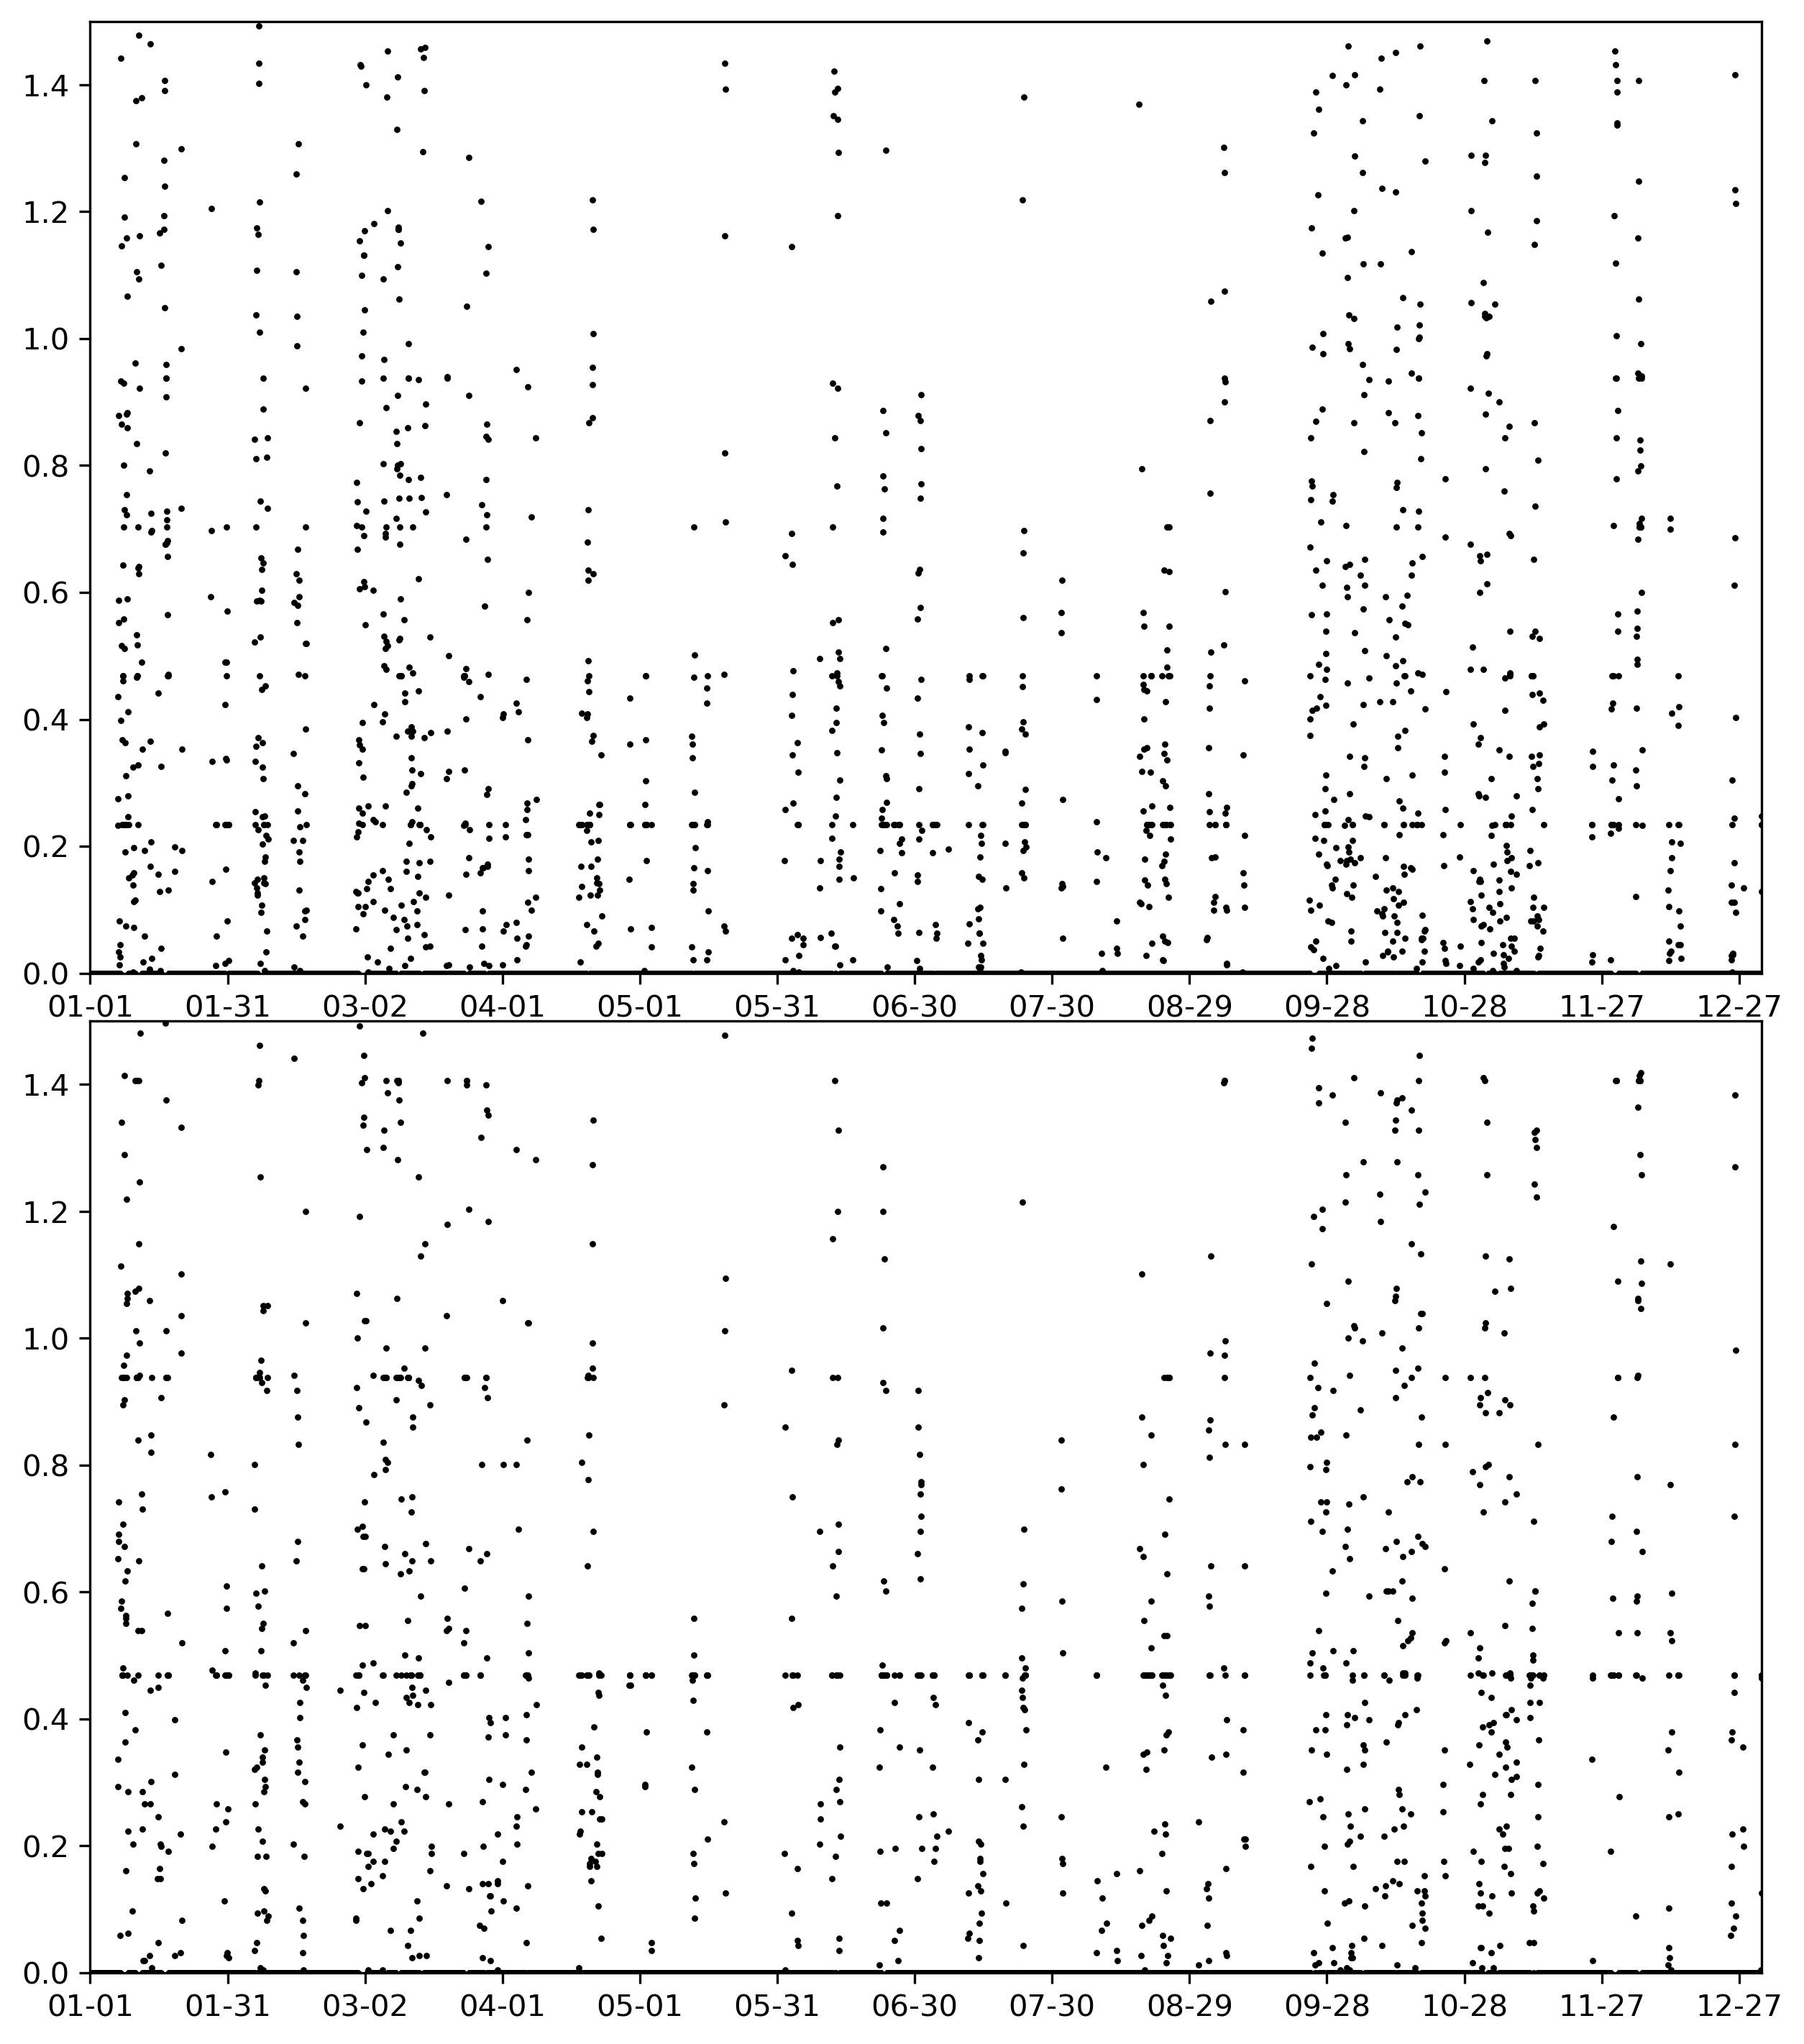

In [16]:
from matplotlib.gridspec import GridSpec
# Create figure
fig = plt.figure(figsize=(10, 11.75))
fig.dpi = 300
fname = path_to_figs + 'WRF_artifact_test'
fmt = 'png'

nrows = 2
ncols = 1

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1], width_ratios = [1], wspace=0.05, hspace=0.05)
## use gs[rows index, columns index] to access grids

ax = fig.add_subplot(gs[0, 0])
ax.scatter(x, y, s=5, c='k', marker='.')
ax.set_ylim(0, 1.5)
dt = 30*24
ax.set_xticks(xticks[::dt]) # set the labels every 15 days
ax.set_xticklabels(x_lbl[::dt], fontsize=10)
ax.set_xlim(x.min(), x.max())

ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(x, z, s=5, c='k', marker='.')
ax2.set_ylim(0, 1.5)
ax2.set_xticks(xticks[::dt]) # set the labels every 15 days
ax2.set_xticklabels(x_lbl[::dt], fontsize=10)
ax2.set_xlim(x.min(), x.max())

plt.show()